In [40]:
import pandas_datareader as pdr
import datetime
import pandas as pd

# Define the start and end dates for the data
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2030, 1, 1)

# Fetch 10-year constant maturity Treasury rates
cmt_data_10y = pdr.get_data_fred("GS10", start_date, end_date, freq='M')
cmt_data_10y['time to maturity'] = range(1, len(cmt_data_10y) + 1)





# Display the data
print(cmt_data_10y)


            GS10  time to maturity
DATE                              
2010-01-01  3.73                 1
2010-02-01  3.69                 2
2010-03-01  3.73                 3
2010-04-01  3.85                 4
2010-05-01  3.42                 5
...          ...               ...
2023-06-01  3.75               162
2023-07-01  3.90               163
2023-08-01  4.17               164
2023-09-01  4.38               165
2023-10-01  4.80               166

[166 rows x 2 columns]


In [41]:
len(cmt_data_10y)

166

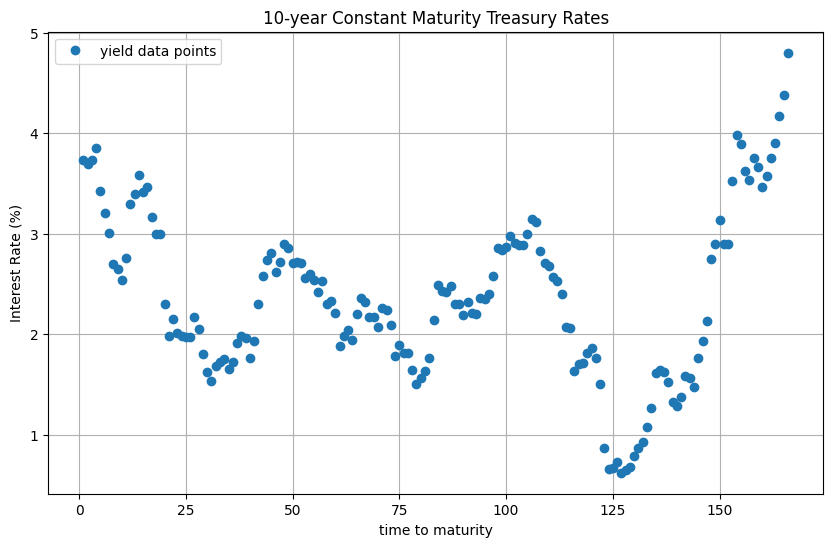

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
#plt.scatter(cmt_data_10y.index, cmt_data_10y['GS10'], label='10-year CMT', color='blue', marker='o')
plt.title('10-year Constant Maturity Treasury Rates')
plt.xlabel('time to maturity')
plt.ylabel('Interest Rate (%)')
plt.plot(cmt_data_10y['time to maturity'], cmt_data_10y['GS10'], 'o', label = 'yield data points')
plt.legend()
plt.grid(True)
plt.show()

### Cubic spline

In [43]:
import numpy as np
import pandas as pd
from datetime import datetime, date, time, timedelta
from dateutil.relativedelta import relativedelta
from scipy.interpolate import CubicSpline
# from scipy.optimize import least_squares

In [44]:
cs = CubicSpline(cmt_data_10y['time to maturity'], cmt_data_10y['GS10'])
curve_points = np.linspace(min(cmt_data_10y['time to maturity']), max(cmt_data_10y['time to maturity']), 1000)

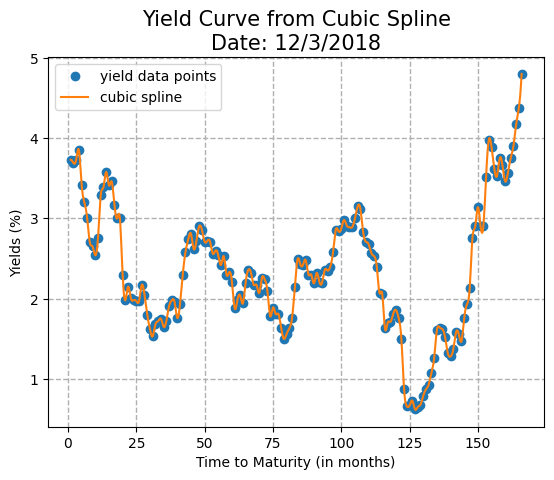

In [45]:
plt.figure()
plt.title('Yield Curve from Cubic Spline\nDate: 12/3/2018', fontsize = 15)
plt.xlabel('Time to Maturity (in months)')
plt.ylabel('Yields (%)')
plt.plot(cmt_data_10y['time to maturity'], cmt_data_10y['GS10'], 'o', label = 'yield data points')
plt.plot(curve_points, cs(curve_points), label="cubic spline")
plt.grid(linestyle = '--', linewidth = 1)
plt.legend()
plt.show()

# nelson

In [46]:
lamda = 0.0605
b0 = 1
b1 = 1
b2 = 1
beta = [b0, b1, b2]

In [47]:

def NS_yield(time_, beta_):
    level_factor =  1
    slope_factor = (1 - np.exp((-1)*lamda*time_))/(lamda*time_)
    curvature_factor = (1 - np.exp((-1)*lamda*time_))/(lamda*time_) - np.exp((-1)*lamda*time_)
    return (beta_[0]*level_factor + beta_[1]*slope_factor + beta_[2]*curvature_factor)

In [48]:
def factor_loading(time_):
    level_factor_loading = []
    slope_factor_loading = []
    curvature_factor_loading = []
    for i in time_:
        level_factor_loading.append(1)
        slope_factor_loading.append((1 - np.exp((-1)*lamda*i))/(lamda*i))
        curvature_factor_loading.append((1 - np.exp((-1)*lamda*i))/(lamda*i) - np.exp((-1)*lamda*i))
    
    return level_factor_loading, slope_factor_loading, curvature_factor_loading

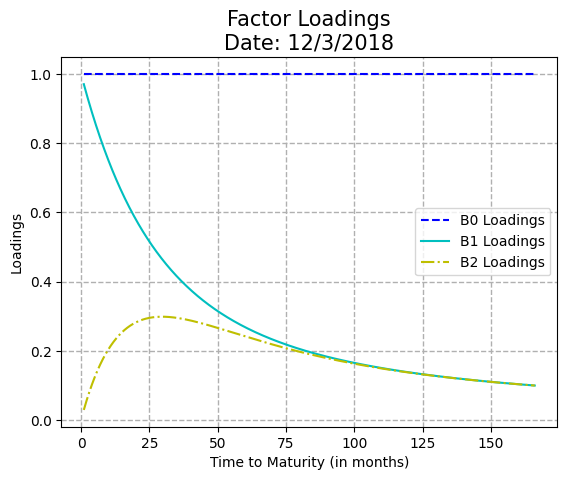

In [49]:
b0_loading, b1_loading, b2_loading = factor_loading(curve_points)

plt.figure()
plt.title('Factor Loadings\nDate: 12/3/2018', fontsize = 15)
plt.xlabel('Time to Maturity (in months)')
plt.ylabel('Loadings')
plt.plot(curve_points, b0_loading, '--', color = 'b', label = 'B0 Loadings')
plt.plot(curve_points, b1_loading, '-', color = 'c', label="B1 Loadings")
plt.plot(curve_points, b2_loading, '-.', color = 'y', label="B2 Loadings")
plt.grid(linestyle = '--', linewidth = 1)
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.title('Yield Curve from NelsonSiegel\nDate: 12/3/2018', fontsize = 15)
plt.xlabel('Time to Maturity (in months)')
plt.ylabel('Yields (%)')
plt.plot(cmt_data_10y['time to maturity'], cmt_data_10y['GS10'], 'o', label = 'yield data points')
plt.plot(curve_points, NS_yield(curve_points, optimum_beta), label="Nelson Siegel")
plt.grid(linestyle = '--', linewidth = 1)
plt.legend()
plt.show()